In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply

In [3]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz
    
    return Hxx, Hz

In [4]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [5]:
# compute correlator
dt = 1e-2
n = 12
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X e^-iHt X |psi>
Cs = np.einsum('j, ij -> i', psi.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.266407934929784
Excited state energy: -19.52953059144965


['/Users/Giovanni/miniconda3/envs/Computational/lib/python312.zip', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/lib-dynload', '', '/Users/Giovanni/miniconda3/envs/Computational/lib/python3.12/site-packages']
/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job
4
3
2
1
0
[0, 1, 2, 3]


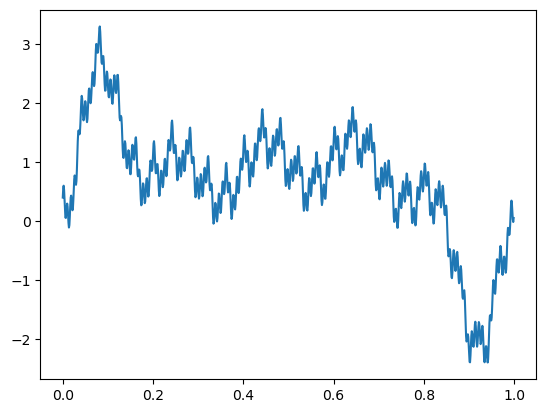

38.7220856309729 3.2946521076008946


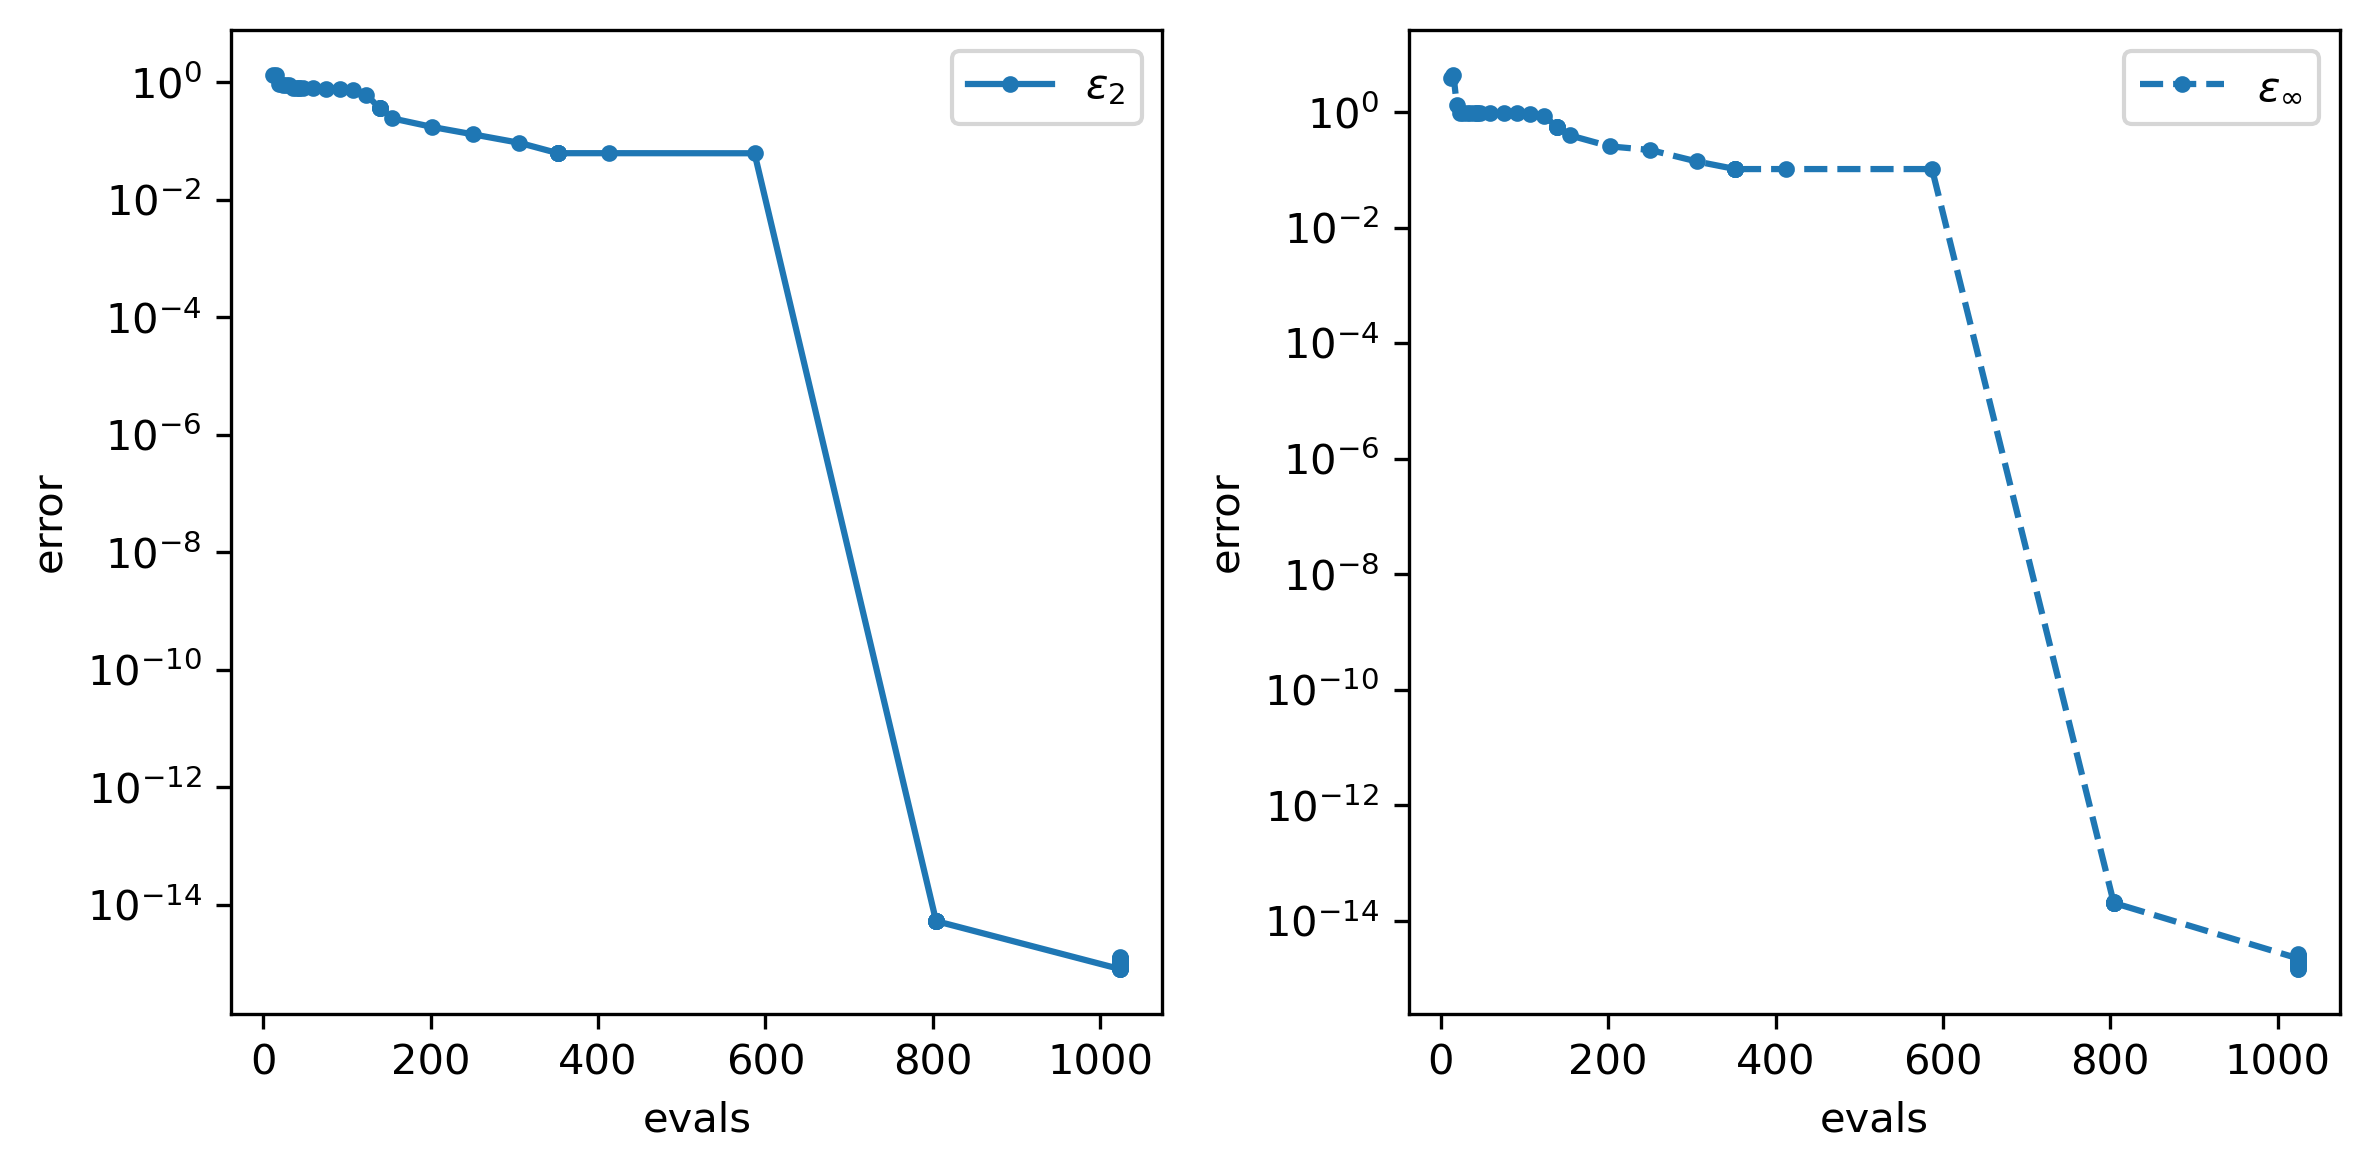

In [13]:
import sys
#sys.path.append("/Users/Giovanni/Desktop/ResearchJob/Student-Research-Job")
print(sys.path)

import os
print(os.getcwd())

import TCI_pythonversion

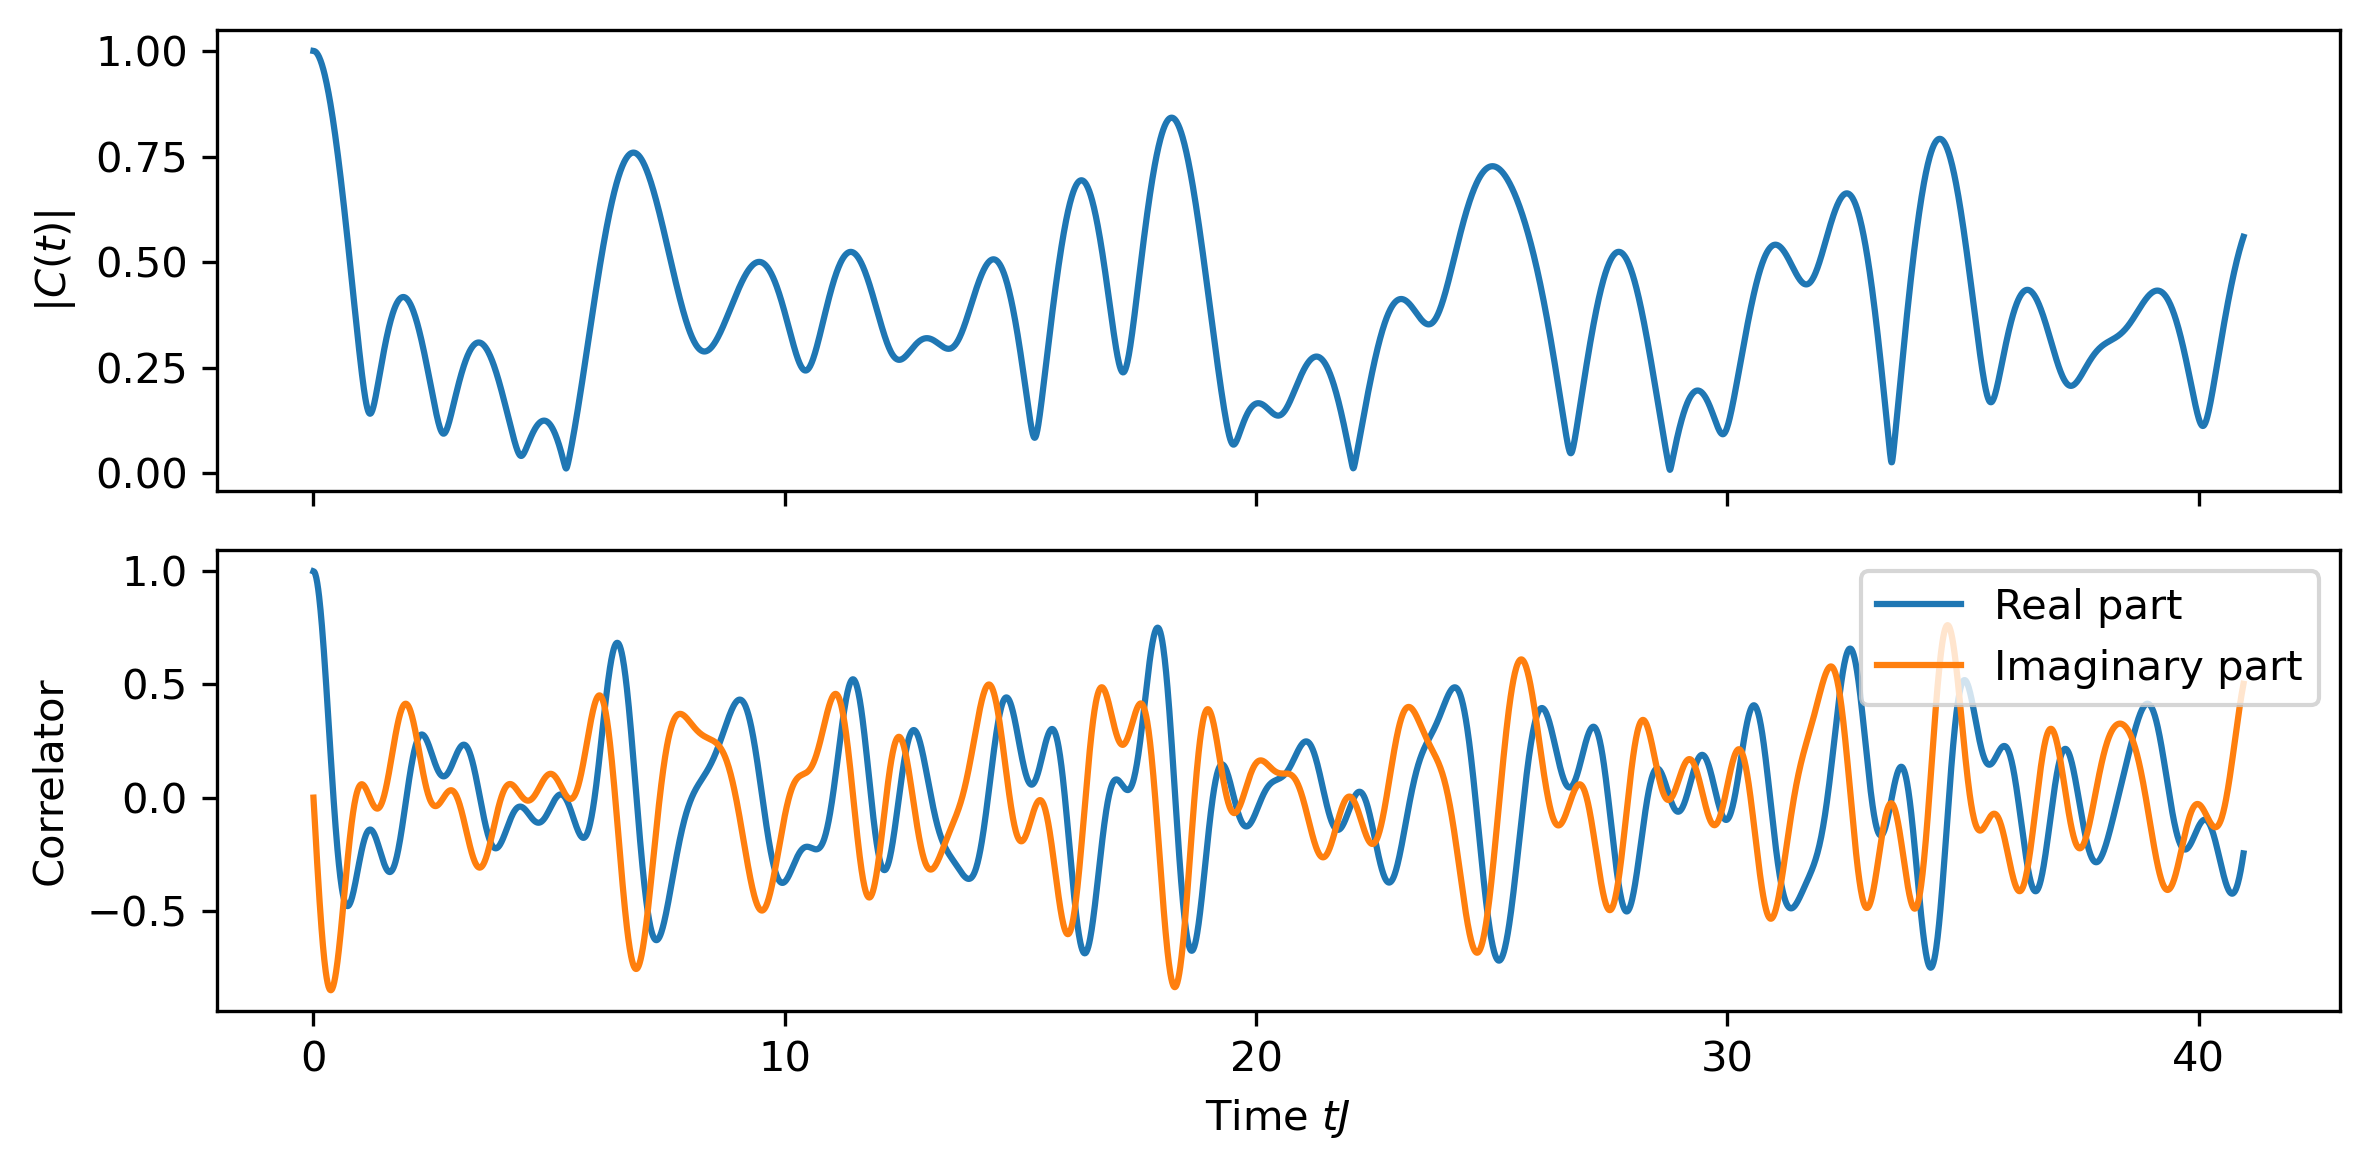

In [7]:
# plot real, imaginary part and absolute value
fig, axs = plt.subplots(nrows=2, dpi=300, figsize=(8,4), sharex=True)

axs[0].plot(np.arange(N)*dt, np.abs(Cs))
axs[0].set(ylabel=r'$|C(t)|$')
axs[1].plot(np.arange(N)*dt, Cs.real, label='Real part')
axs[1].plot(np.arange(N)*dt, Cs.imag, label='Imaginary part')
axs[1].set(xlabel=r'Time $tJ$',
           ylabel=r'Correlator')
axs[1].legend()

plt.tight_layout()
plt.show()

In [11]:
# Fourier transform the time-domain with windowing function cos(pi/2 * t/T)**nw
def timeFT(Ct, t_list, nw=4):
    """
    full complex data as input. 
    data only for positive time.
    """
    
    n = len(t_list)
    Wfunlist = [np.cos(np.pi*t_list[t]/(2*t_list[-1]))**nw  for t in range(n)]
    
    input_list = Wfunlist[:] * (np.array(Ct[:]))
    FTresult = np.fft.fft(input_list)
    
    freq = 2 * np.pi * np.fft.fftfreq(n, t_list[1]-t_list[0])
    freq = np.fft.fftshift(freq)
    FTresult = np.fft.fftshift(FTresult)
    
    return freq, FTresult

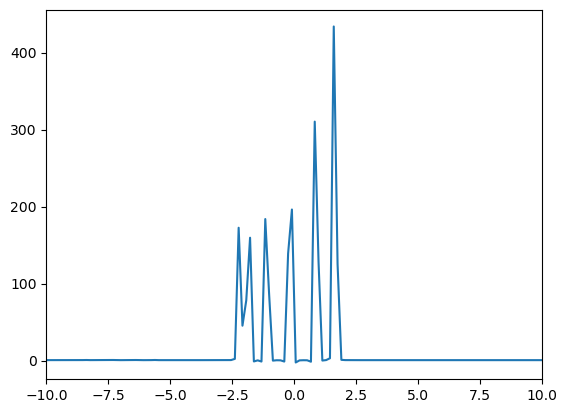

In [12]:
freq, FTresult = timeFT(Ct=Cs, t_list=np.arange(N)*dt, nw=3)
plt.plot(freq-E0+E1, np.real(FTresult))
plt.xlim(-10,10)
plt.show()